### MODELLO
Per affrontare il problema ho implementato un'architettura **Conditional Autoencoder**, basata su reti convoluzionali.
Ho sfruttato il label di classe (y_train) come input aggiuntivo, per permettere un completamento dell'immagine più coeso.

#### Il modello che ho usato
Il mio modello attuale ha 32 filtri nel primo layer e 64 nel secondo, con spazio latente di dimensione 256 per permettere un addestramento rapido e accurato.

#### Altri tentativi
I parametri del modello sono stati scelti attraverso trial and error, con diversi pesi.
- Ho provato ad usare un modello "leggero" con 8 filtri nel primo layer e 16 nel secondo, con uno spazio latente ridotto, però è stato scartato per la nitidezza, che non era sufficiente
- E' stato provato anche un modello "pesante", con 3 strati convolutivi, risultava tuttavia un overfitting molto precoce e non risultava un miglioramento rispetto al modello utilizzato

In [25]:
import numpy as np
import tensorflow as tf


from keras.layers import Input, Conv2D, Conv2DTranspose, Concatenate, Embedding, Flatten, Dense, Reshape, Activation, BatchNormalization, Cropping2D
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from keras.datasets import mnist

import matplotlib.pyplot as plt

In [26]:


#carichiamo i dati
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalizzazione
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0


x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [27]:

def split_images(x):
    #Tagliamo sull'asse delle colonne (axis 2)
    x_in = x[:, :, :14, :]   
    x_out = x[:, :, 14:, :] 
    return x_in, x_out

x_train_in, x_train_out = split_images(x_train)
x_test_in, x_test_out = split_images(x_test)


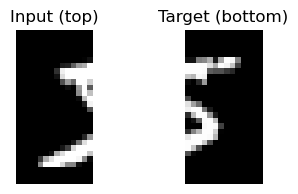

In [28]:
def show_example(x_in, x_out):
    plt.figure(figsize=(4,2))

    plt.subplot(1,2,1)
    plt.imshow(x_in[0,:,:,0], cmap="gray")
    plt.title("Input (top)")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(x_out[0,:,:,0], cmap="gray")
    plt.title("Target (bottom)")
    plt.axis("off")

    plt.show()

show_example(x_train_in, x_train_out)


In [29]:
mean_digit = np.mean(x_train_out, axis=0, keepdims=True)

def baseline_prediction(x):
    return np.repeat(mean_digit, x.shape[0], axis=0)


### Definizione Metrica di valutazione
In questa sezione calcoliamo l'immagine media per ogni singola classe, (quindi per esempio la media per tutti gli '1')

La funzione `evaluation_conditional` mi calcola il rapporto tra l'errore del mio modello e quello della baseline.

In [30]:

mean_digits = np.zeros((10, 28, 14, 1)) 

for i in range(10):
    #Prendiamo tutte le immagini di train della classe i
    imgs = x_train_out[y_train == i]
    mean_digits[i] = np.mean(imgs, axis=0)

print("Baseline calcolata correttamente con shape:", mean_digits.shape)


def evaluation_conditional(model, x_in, y_true_img, labels):
    #Predizione del modello
    preds = model.predict([x_in, labels], verbose=0)
    
    #Calcolo MSE del modello
    mse_model = np.mean((y_true_img - preds)**2)
    
    #Calcolo MSE della baseline
    baseline_preds = np.array([mean_digits[label] for label in labels])
    mse_baseline = np.mean((y_true_img - baseline_preds)**2)
    
    print(f"MSE Modello: {mse_model:.5f}")
    print(f"MSE Baseline (Class-Cond): {mse_baseline:.5f}")
    print(f"Rapporto: {mse_model / mse_baseline:.5f}")
    
    return mse_model / mse_baseline

Baseline calcolata correttamente con shape: (10, 28, 14, 1)


Questo modello utilizza un Conditional Autoencoder, uso il Cropping2D nel decoder per permettermi di gestire l'asimmetria introdotta dagli stride, combaciando l'output a 28x14 px (come il target).

In [31]:


def build_medium_model_corrected():
    img_input = Input(shape=(28, 14, 1), name='img_input')
    
    # Encoder
    x = Conv2D(32, (3, 3), padding='same', strides=2)(img_input)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same', strides=2)(x)
    x = Activation('relu')(x)
    
    x = Flatten()(x)
    
    #label
    label_input = Input(shape=(1,), name='label_input')
    l = Embedding(input_dim=10, output_dim=30)(label_input)
    l = Flatten()(l)
    

    concat = Concatenate()([x, l])
    
    h = Dense(256, activation='relu')(concat)
    
    # Decoder
    h = Dense(7 * 4 * 64, activation='relu')(h)
    h = Reshape((7, 4, 64))(h)
    
    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same')(h)
    x = Activation('relu')(x)

    x = Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x)
    x = Activation('relu')(x)
    
    #Tagliamo via i 2 pixel di troppo (1 a sinistra, 1 a destra)
    x = Cropping2D(cropping=((0, 0), (1, 1)))(x) 
    
    #Output finale
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    model = Model(inputs=[img_input, label_input], outputs=decoded)
    return model

#Costruiamo e compiliamo il modello corretto
model = build_medium_model_corrected()
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_input (InputLayer)         [(None, 28, 14, 1)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 14, 7, 32)    320         ['img_input[0][0]']              
                                                                                                  
 activation_8 (Activation)      (None, 14, 7, 32)    0           ['conv2d_6[0][0]']               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 7, 4, 64)     18496       ['activation_8[0][0]']           
                                                                                            

La funzione **ReduceLROnPlateau** monitora la `val_loss` per ridurre il learning rate, questo perché in caso ci si avvicini ad un minimo locale possiamo migliorare la precisione.

Invece la funzione **EarlyStopping** interrompe l'addestramento se non si notano miglioramenti dopo una serie di epoche dove non si migliora (per gestire eventuali situazioni di fluttuamento), allo stesso tempo garantisce che il modello finale non sia quello finale ma quello che ha avuto una performance migliore.

In [32]:


# Aumentiamo la pazienza per dare tempo al modello di imparare
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(
    [x_train_in, y_train],
    x_train_out,
    validation_data=([x_test_in, y_test], x_test_out),
    epochs=25,          
    batch_size=256,     
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/25
235/235 [==============================] - 41s 168ms/step - loss: 0.0666 - val_loss: 0.0391 - lr: 0.0010
Epoch 2/25
235/235 [==============================] - 39s 167ms/step - loss: 0.0348 - val_loss: 0.0322 - lr: 0.0010
Epoch 3/25
235/235 [==============================] - 40s 169ms/step - loss: 0.0310 - val_loss: 0.0304 - lr: 0.0010
Epoch 4/25
235/235 [==============================] - 39s 166ms/step - loss: 0.0294 - val_loss: 0.0289 - lr: 0.0010
Epoch 5/25
235/235 [==============================] - 39s 165ms/step - loss: 0.0284 - val_loss: 0.0284 - lr: 0.0010
Epoch 6/25
235/235 [==============================] - 39s 167ms/step - loss: 0.0276 - val_loss: 0.0281 - lr: 0.0010
Epoch 7/25
235/235 [==============================] - 39s 167ms/step - loss: 0.0270 - val_loss: 0.0277 - lr: 0.0010
Epoch 8/25
235/235 [==============================] - 39s 165ms/step - loss: 0.0265 - val_loss: 0.0276 - lr: 0.0010
Epoch 9/25
235/235 [==============================] - 39s 167ms/step - l

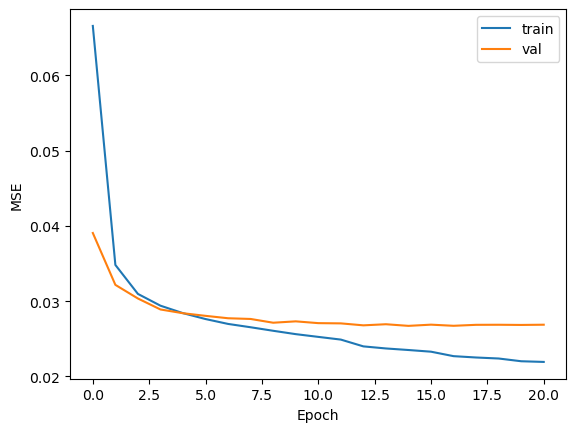

In [33]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()


In [34]:
# Calcola la loss attuale del modello
val_loss_finale = model.evaluate([x_test_in, y_test], x_test_out, verbose=0)

print(f"Loss del modello attuale: {val_loss_finale:.5f}")
print(f"Miglior loss nel training: {min(history.history['val_loss']):.5f}")


Loss del modello attuale: 0.02672
Miglior loss nel training: 0.02672


Faccio una verifica dei pesi, confrontando la loss attuale del modello con la minima registrata nella history, usata per verificare che l'early stopping funzionasse. Si conferma che funziona (infatti il training viene bloccato all'epoca 21)

Nella cella successiva faccio un calcolo del rapporto, che mi permette di alutare il modello. 
Il risultato è 0.466.

In [35]:

# Valutazione sul test set
res = evaluation_conditional(model, x_test_in, x_test_out, y_test)


MSE Modello: 0.02672
MSE Baseline (Class-Cond): 0.05733
Rapporto: 0.46610


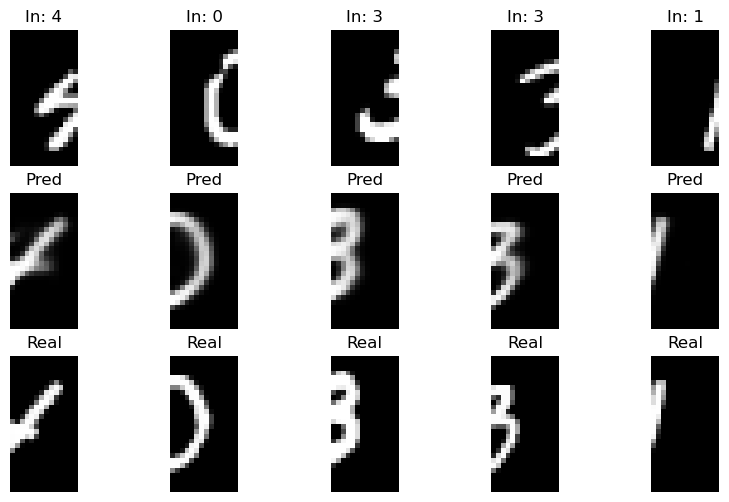

In [40]:
import matplotlib.pyplot as plt
def show_example_cond(x_in, labels, x_out):
    preds = model.predict([x_in, labels], verbose=0)
    
    n = 5
    plt.figure(figsize=(10, 6))
    for i in range(n):
        # Input
        plt.subplot(3, n, i + 1)
        plt.imshow(x_in[i, :, :, 0], cmap="gray")
        plt.title(f"In: {labels[i]}")
        plt.axis("off")

        # Predizione
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(preds[i, :, :, 0], cmap="gray")
        plt.title("Pred")
        plt.axis("off")

        # Ground Truth
        plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(x_out[i, :, :, 0], cmap="gray")
        plt.title("Real")
        plt.axis("off")
    plt.show()

# Selezioniamo 5 indici casuali
idx = np.random.randint(0, x_test.shape[0], 5)
show_example_cond(x_test_in[idx], y_test[idx], x_test_out[idx])

In [37]:
model.save("mnist_completion_model.h5")


In [39]:
import os
import gdown
from keras.models import load_model


file_id = '1TD8UGckYO0BGkRdmbWT6frNaQ0PzFsZI'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'mnist_completion_model.h5'


if not os.path.exists(output):
    print("Scaricamento del modello da Google Drive...")
    gdown.download(url, output, quiet=False)


loadedModel = load_model(output)
evaluation_conditional(loadedModel, x_test_in, x_test_out, y_test)


MSE Modello: 0.02672
MSE Baseline (Class-Cond): 0.05733
Rapporto: 0.46610


0.466100739256124

Nella parte finale ho scaricato automaticamente i pesi che ho caricato sul google drive, rendendoli utilizzabili ed eseguibili senza dover riaddestrare il modello. 

Dopo averlo caricato posso fare una verifica di `model` per confrontare il risultato.